<a href="https://colab.research.google.com/github/AchrafIbrahim/Prediction_of_Damaged_Soil_Moisture_Sensor_Data/blob/main/Prediction_of_Damaged_Soil_Moisture_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICTION OF DAMAGED SOIL MOISTURE SENSOR DATA**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [2]:
data_sensor = pd.read_excel('Data - Baru Usable (17 Apr - 02 May).xlsx')
data_cuaca = pd.read_excel('Data - Cuaca (17 April - 2 Mei 2023).xlsx')

## **PREPROCESSING**

In [3]:
data_cuaca.drop(['YEAR', 'MO', 'DY', 'HR', 'Tanggal', 'Jam'], axis=1, inplace=True)
data_sensor.drop(['Kelembapan Tanah 2', 'Z1', 'Z2', 'Action 1', 'Action 2', 'Tanggal', 'Jam'], axis=1, inplace=True)

#Change datatype
data_cuaca['Tanggal dan Jam'] = pd.to_datetime(data_cuaca['Tanggal dan Jam'])
data_sensor['Tanggal dan Jam'] = pd.to_datetime(data_sensor['Tanggal dan Jam'])

#Drop Duplicates
data_sensor = data_sensor.drop_duplicates(subset=['Tanggal dan Jam'])

In [4]:
#Hapus Outlier
data_sensor = data_sensor.drop(data_sensor[(data_sensor['Kelembapan Tanah 1']<11) & (data_sensor['Sensor Suhu']>36)].index)
data_sensor = data_sensor.drop(data_sensor[(data_sensor['Kelembapan Tanah 1']>80) & (data_sensor['Sensor Suhu']<30)].index)

In [5]:
#Data Selection
data_sensor.set_index('Tanggal dan Jam', inplace=True)
start = '2023-04-17 13:00:50'
end = '2023-04-26 08:53:42'
data_sensor = data_sensor.loc[start:end]
data_sensor = data_sensor.reset_index()

#Hourly Data Sensor
data_sensor.set_index('Tanggal dan Jam', inplace=True)
data_sensor = data_sensor.resample('H').mean()
data_sensor = data_sensor.reset_index()

#Data cuaca selection
data_cuaca.set_index('Tanggal dan Jam', inplace=True)
start = '2023-04-17 13:00:00'
end = '2023-04-26 08:00:00'
data_cuaca = data_cuaca.loc[start:end]
data_cuaca = data_cuaca.reset_index()

In [6]:
#Join Dataset
data_cuaca.set_index(['Tanggal dan Jam'], inplace=True)
data_sensor.set_index(['Tanggal dan Jam'], inplace=True)
data = pd.merge(data_sensor, data_cuaca, left_index=True, right_index=True)

## **KMEANS**

In [7]:
x_kmeans = data[['Kelembapan Tanah 1', 'Sensor Suhu', 'Sensor Hujan']]

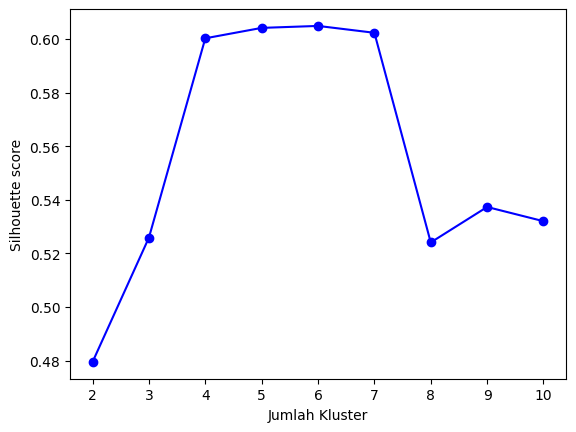

In [8]:
scaler = MinMaxScaler()
x_kmeans = scaler.fit_transform(x_kmeans)

#Optimum Cluster number
k = range(2, 11)
ss = []
for n_clusters in k:
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
  cluster_label = kmeans.fit_predict(x_kmeans)
  sil_avg = silhouette_score(x_kmeans, cluster_label)
  ss.append(sil_avg)

# Visualisasi Silhouette Score
plt.plot(k, ss, 'bo-')
plt.xlabel('Jumlah Kluster')
plt.ylabel('Silhouette score')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0, n_init=5, max_iter=300)
hasil_kluster = kmeans.fit_predict(x_kmeans)
hasil_kluster

array([2, 2, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 2, 2, 1, 0, 0, 1, 1, 4, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

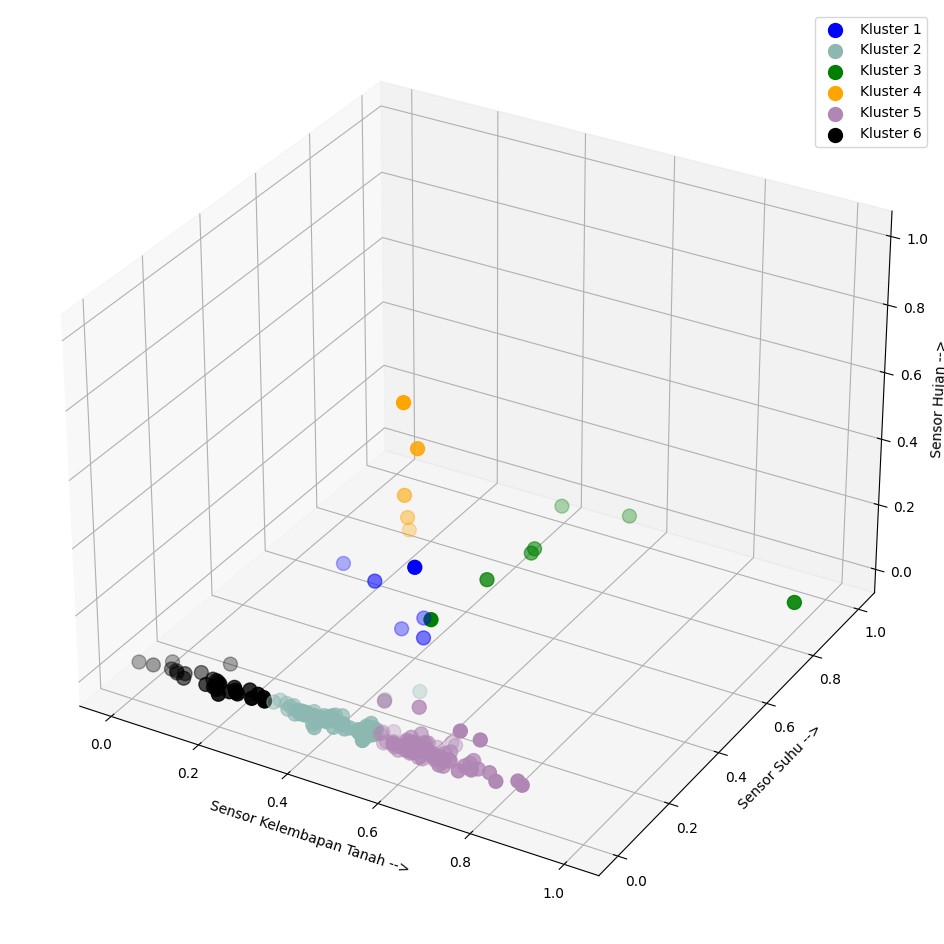

In [10]:
# Visualisasi 3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_kmeans[hasil_kluster==0, 0], x_kmeans[hasil_kluster==0, 1], x_kmeans[hasil_kluster==0, 2], s=100, color='blue', label='Kluster 1')
ax.scatter(x_kmeans[hasil_kluster==1, 0], x_kmeans[hasil_kluster==1, 1], x_kmeans[hasil_kluster==1, 2], s=100, color='#8DB8B2', label='Kluster 2')
ax.scatter(x_kmeans[hasil_kluster==2, 0], x_kmeans[hasil_kluster==2, 1], x_kmeans[hasil_kluster==2, 2], s=100, color='green', label='Kluster 3')
ax.scatter(x_kmeans[hasil_kluster==3, 0], x_kmeans[hasil_kluster==3, 1], x_kmeans[hasil_kluster==3, 2], s=100, color='orange', label='Kluster 4')
ax.scatter(x_kmeans[hasil_kluster==4, 0], x_kmeans[hasil_kluster==4, 1], x_kmeans[hasil_kluster==4, 2], s=100, color='#B086B4', label='Kluster 5')
ax.scatter(x_kmeans[hasil_kluster==5, 0], x_kmeans[hasil_kluster==5, 1], x_kmeans[hasil_kluster==5, 2], s=100, color='black', label='Kluster 6')

# Menambahkan label pada setiap sumbu
ax.set_xlabel('Sensor Kelembapan Tanah -->')
ax.set_ylabel('Sensor Suhu -->')
ax.set_zlabel('Sensor Hujan -->')
ax.legend()

plt.show()

In [11]:
data = data.reset_index()
hasil_kluster = pd.DataFrame(hasil_kluster, columns=['Hasil Kluster'])
data = pd.concat([data, hasil_kluster], axis=1)

## **SVR MODEL**

In [12]:
x = data[['Sensor Suhu', 'Sensor Hujan', 'Hasil Kluster', 'Curah Hujan ', 'Kelembapan Relatif 2m', 'Kecepatan Angin 2m']]
y = data['Kelembapan Tanah 1']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [14]:
#Best params with Grid Search CV
params = {'C':[0.1, 1, 10, 100, 200], 'gamma':[0.1, 1, 10, 100], 'epsilon':[0.01, 0.02, 0.03]}
svr = SVR(kernel='rbf')
model_gs = GridSearchCV(svr, params, cv=5)

model_gs.fit(x_train, y_train)
print("Parameter optimal: ", model_gs.best_params_)

Parameter optimal:  {'C': 200, 'epsilon': 0.03, 'gamma': 1}


In [15]:
model1 = SVR(kernel='rbf', C=100, gamma=10, epsilon=0.01)
model1.fit(x_train, y_train)
y_pred = model1.predict(x_test)

print('Root Mean squared error (RMSE): %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (R2): %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute error (MAE): %.2f' % mean_absolute_error(y_test, y_pred))
print('Mean Absolute Percentage Error (MAPE): %.2f' % mean_absolute_percentage_error(y_test, y_pred))

Root Mean squared error (RMSE): 2.44
Coefficient of determination (R2): 0.85
Mean Absolute error (MAE): 1.82
Mean Absolute Percentage Error (MAPE): 0.03


In [16]:
import joblib

joblib.dump(model1, 'Model.pkl')

['Model.pkl']

In [17]:
#Load model
model = joblib.load('Model.pkl')

x = data[['Sensor Suhu', 'Sensor Hujan', 'Hasil Kluster', 'Curah Hujan ', 'Kelembapan Relatif 2m', 'Kecepatan Angin 2m']]

x = scaler.fit_transform(x)
data_predict = model.predict(x)

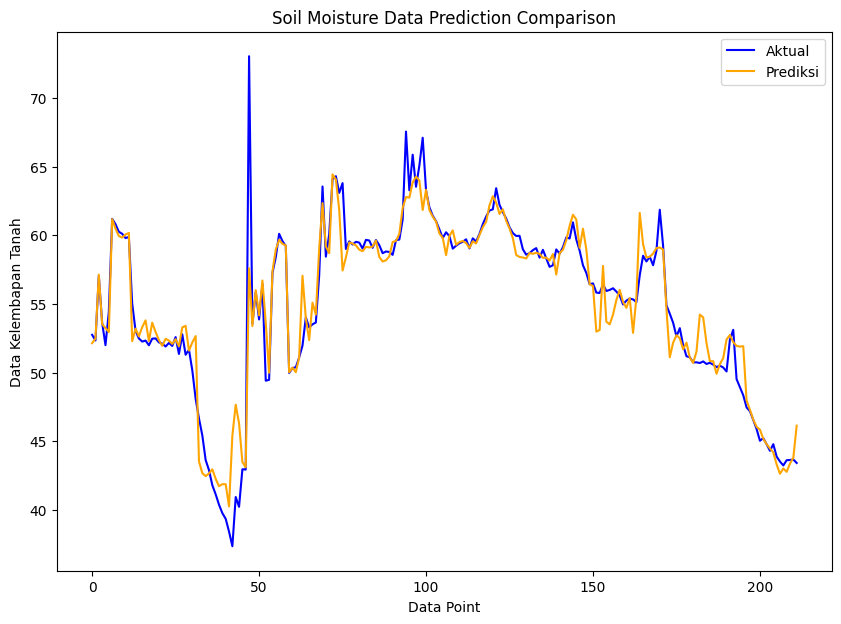

In [18]:
data_w_predict = data
data_w_predict['SM Predict'] = data_predict

plt.figure(figsize=(10, 7))
plt.plot(data_w_predict['Kelembapan Tanah 1'], label='Aktual', color='blue')
plt.plot(data_w_predict['SM Predict'], label='Prediksi', color='orange')
plt.xlabel('Data Point')
#plt.xticks(rotation=90)
plt.ylabel('Data Kelembapan Tanah')
plt.title('Soil Moisture Data Prediction Comparison')
plt.legend()
plt.show()

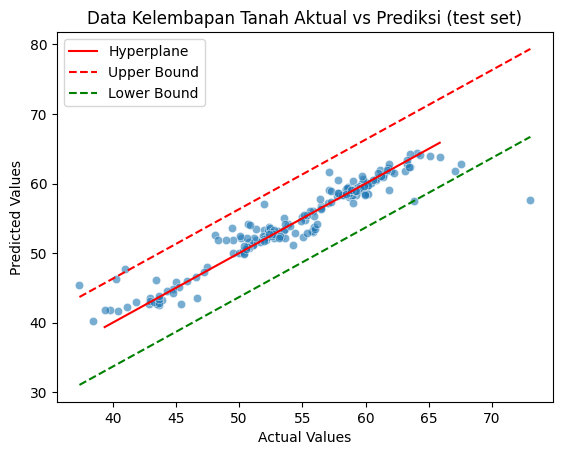

In [19]:
a = data_w_predict['Kelembapan Tanah 1']
b = data_w_predict['SM Predict']

sns.scatterplot(x=a, y=b, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Hyperplane')

residuals = y_test - y_pred
epsilon = np.percentile(np.abs(residuals), 100 * (1 - model1.epsilon))
i = y+epsilon
j = y-epsilon
# Plot garis batas epsilon berdasarkan prediksi model
sns.lineplot(x=a, y=i, color='red', linestyle='--', label='Upper Bound')
sns.lineplot(x=a, y=j, color='green', linestyle='--', label='Lower Bound')
#plt.plot(a, y + epsilon, color='red', linestyle='--', label=f'Epsilon Upper Bound')
#plt.plot(a, y - epsilon, color='green', linestyle='--', label=f'Epsilon Lower Bound')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Data Kelembapan Tanah Aktual vs Prediksi (test set)')
plt.show()

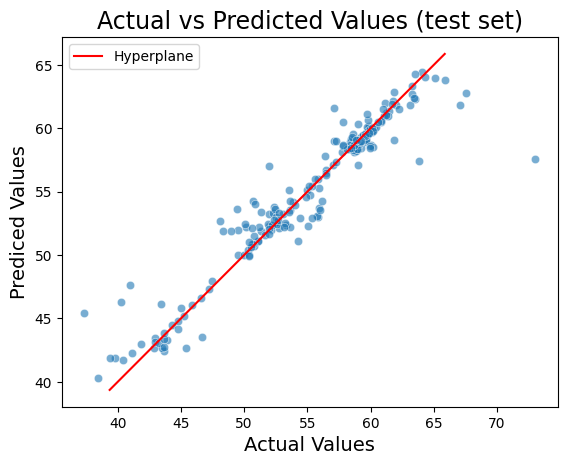

In [20]:
sns.scatterplot(x=a, y=b, alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', label='Hyperplane')
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Prediced Values', fontsize=14)
plt.title('Actual vs Predicted Values (test set)', fontsize=17)
plt.show()